In [12]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# --- 1. FUNCIONES DE CARGA ---

# Función A: Para tus archivos "Latinos" (separador ; y decimal ,)
def cargar_local_latino(filepath, col_fecha, col_valor, nuevo_nombre):
    df = pd.read_csv(filepath, sep=';', decimal=',')
    df['date'] = pd.to_datetime(df[col_fecha], dayfirst=True, errors='coerce')
    df = df.set_index('date')[[col_valor]].rename(columns={col_valor: nuevo_nombre})
    return df.sort_index()

# Función B: Para archivos estándar (separador , y decimal .) como el RI_n y GDELT
def cargar_standard(filepath, col_fecha, col_valor, nuevo_nombre):
    df = pd.read_csv(filepath) # Por defecto sep=',' y decimal='.'
    df['date'] = pd.to_datetime(df[col_fecha])
    df = df.set_index('date')[[col_valor]].rename(columns={col_valor: nuevo_nombre})
    return df.sort_index()

print("⏳ Cargando batería de datos locales...")

# --- 2. CARGA DE DATOS LOCALES ---

# 2.1 Target EMBI
df_embi = cargar_local_latino('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/EMBI_Ecuador_2004_2025.csv', 
                              'Período', 'Riesgo País en Puntos básicos', 'target_embi')

# 2.2 Variables Nuevas (Formato Latino)
df_balanza = cargar_local_latino('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/saldo-balanza-comercial.csv', 
                                 'Período', 'Saldo Balanza Comercial en Millones USD FOB', 'macro_balanza_comercial')

df_desempleo = cargar_local_latino('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/tasa-de-desempleo-nacion.csv', 
                                   'Período', 'Tasa de desempleo nacional en Porcentaje - Mensual', 'macro_desempleo')

df_remesas = cargar_local_latino('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/remesas-de-trabajadores.csv', 
                                 'Período', 'Remesas de trabajadores en millones de U.S. dólares', 'macro_remesas')

df_prod_petro = cargar_local_latino('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/produccin-petrolera-naci.csv', 
                                    'Período', 'Producción Petrolera Nacional en Barriles - Diaria', 'macro_prod_petroleo')

df_liquidez = cargar_local_latino('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/liquidez-total-m2.csv', 
                                    'Período', 'LIQUIDEZ TOTAL M2 en Millones de dólares al final de período', 'macro_liquidez')

# 2.3 Reservas Internacionales
print("   -> Cargando Reservas desde Excel...")
df_reservas = pd.read_excel('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/RI.xlsx',
                            sheet_name='RI_n')

# a. Convertimos a string
df_reservas['Período'] = df_reservas['Período'].astype(str)

# b. Limpieza de basura (notas al pie)
df_reservas['Período'] = df_reservas['Período'].str.replace(r' \(\d+\)', '', regex=True)

# c. SOLUCIÓN ROBUSTA: format='mixed' permite que convivan distintos formatos
# dayfirst=True ayuda a desambiguar cuando sea posible (ej. 01/02 vs 02/01)
df_reservas['date'] = pd.to_datetime(df_reservas['Período'], dayfirst=True, format='mixed')

# d. Formato final
df_reservas = df_reservas.set_index('date')[['Reservas Internacionales (Millones de dólares)']]
df_reservas.columns = ['macro_reservas_int']
df_reservas = df_reservas.sort_index()

print("✅ Reservas cargadas correctamente (Formatos mixtos resueltos).")

# --- 3. UNIFICACIÓN DE GDELT (NLP) ---
print("⏳ Unificando historia de GDELT (2004-2025)...")

# Cargar los dos archivos
nlp_old = pd.read_csv('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/gdelt_20040101_20150218.csv')
nlp_new = pd.read_csv('C:/Users/danny/Maestría Ciencia de Datos USFQ/tesis-riesgo-pais-ecuador/data/raw/gdelt_20150218_20251231.csv')

# Unirlos verticalmente
df_nlp_full = pd.concat([nlp_old, nlp_new], ignore_index=True)

# Limpieza y formato fecha
df_nlp_full['date'] = pd.to_datetime(df_nlp_full['SQLDATE'].astype(str), format='%Y%m%d')
df_nlp = df_nlp_full.set_index('date')[['avg_tone', 'avg_goldstein', 'event_count']]
df_nlp.columns = ['nlp_avg_tone', 'nlp_goldstein', 'nlp_event_count']

# Agrupar por fecha (por si hay duplicados al unir las fronteras de los archivos)
df_nlp = df_nlp.groupby('date').mean()

print(f"✅ GDELT unificado. Filas totales: {len(df_nlp)}")

# --- 4. DATOS EXTERNOS (YFINANCE) ---
dict_tickers = {
    'CL=F': 'oil_wti',          
    '^TNX': 'us_treasury_10y', 
    'GC=F': 'gold',             
    '^VIX': 'volatility_vix',   
    'DX-Y.NYB': 'index_dxy',    
    'EMB': 'etf_emb',           
    'HYG': 'etf_hyg'            
}
print("⏳ Descargando financieros externos...")
df_external = yf.download(list(dict_tickers.keys()), start='2004-01-01', progress=False)['Close']
df_external = df_external.rename(columns=dict_tickers)
df_external.index.name = 'date'

# --- 5. CREACIÓN DEL MASTER DATASET (2008-2025) ---
print("⏳ Uniendo todo en el Dataset Maestro...")

# Usamos el índice de EMBI como base
df_master = df_embi.join([df_external, df_nlp, df_reservas, df_balanza, df_desempleo, df_remesas, df_prod_petro, df_liquidez], how='left')

# FILTRO DE TIEMPO: Enero 2008 a Diciembre 2025
df_master = df_master.loc['2008-01-01':'2025-12-31']

# Imputación (Forward Fill) para variables mensuales/trimestrales
# Esto rellena los días vacíos con el último dato mensual conocido
df_master = df_master.ffill()

print("\n🎉 ¡DATASET FINAL LISTO!")
print(f"Rango de Fechas: {df_master.index.min()} a {df_master.index.max()}")
print(f"Dimensiones: {df_master.shape}")
print("\nVerificación de nulos (debería ser mínimo):")
print(df_master.isna().sum())

display(df_master.tail())

⏳ Cargando batería de datos locales...
   -> Cargando Reservas desde Excel...


C:\Users\danny\AppData\Local\Temp\ipykernel_2352\2810451072.py:16: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['date'] = pd.to_datetime(df[col_fecha], dayfirst=True, errors='coerce')


✅ Reservas cargadas correctamente (Formatos mixtos resueltos).
⏳ Unificando historia de GDELT (2004-2025)...
✅ GDELT unificado. Filas totales: 7146
⏳ Descargando financieros externos...


C:\Users\danny\AppData\Local\Temp\ipykernel_2352\2810451072.py:104: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df_external = yf.download(list(dict_tickers.keys()), start='2004-01-01', progress=False)['Close']


⏳ Uniendo todo en el Dataset Maestro...

🎉 ¡DATASET FINAL LISTO!
Rango de Fechas: 2008-01-01 00:00:00 a 2025-12-31 00:00:00
Dimensiones: (5878, 17)

Verificación de nulos (debería ser mínimo):
target_embi                   0
oil_wti                       1
index_dxy                     1
etf_emb                       1
gold                          1
etf_hyg                       1
us_treasury_10y               1
volatility_vix                1
nlp_avg_tone                  1
nlp_goldstein                 1
nlp_event_count               1
macro_reservas_int           30
macro_balanza_comercial       0
macro_desempleo               0
macro_remesas              2922
macro_prod_petroleo        3653
macro_liquidez                0
dtype: int64


,target_embi,oil_wti,index_dxy,etf_emb,gold,etf_hyg,us_treasury_10y,volatility_vix,nlp_avg_tone,nlp_goldstein,nlp_event_count,macro_reservas_int,macro_balanza_comercial,macro_desempleo,macro_remesas,macro_prod_petroleo,macro_liquidez
date,,,,,,,,,,,,,,,,,
2025-12-27,502,56.740002,98.019997,96.540001,4529.100098,80.599998,4.136,13.60,-1.768797,1.720000,45.0,9684.868703,361.508402,2.61,2012.705641,463502.77,97449.05
2025-12-28,502,56.740002,98.019997,96.540001,4529.100098,80.599998,4.136,13.60,-2.323340,1.785106,47.0,9684.868703,361.508402,2.61,2012.705641,463502.77,97449.05
2025-12-29,504,58.080002,98.040001,96.589996,4325.100098,80.629997,4.116,14.20,-3.715936,1.805660,53.0,9684.868703,361.508402,2.61,2012.705641,463502.77,97449.05
2025-12-30,501,57.950001,98.239998,96.470001,4370.100098,80.709999,4.130,14.33,-1.594865,1.950000,60.0,9684.868703,361.508402,2.61,2012.705641,463502.77,97449.05
2025-12-31,492,57.419998,98.279999,96.279999,4325.600098,80.629997,4.163,14.95,-0.692512,1.481395,43.0,9795.139885,361.508402,2.61,2012.705641,463502.77,97449.05


##### **Se quedan fuera remesas y producción petrolera local debido a la ventana de tiempo que utilizaremos y la disponibilidad de los datos**

Dimensiones finales del dataset: (5878, 15)


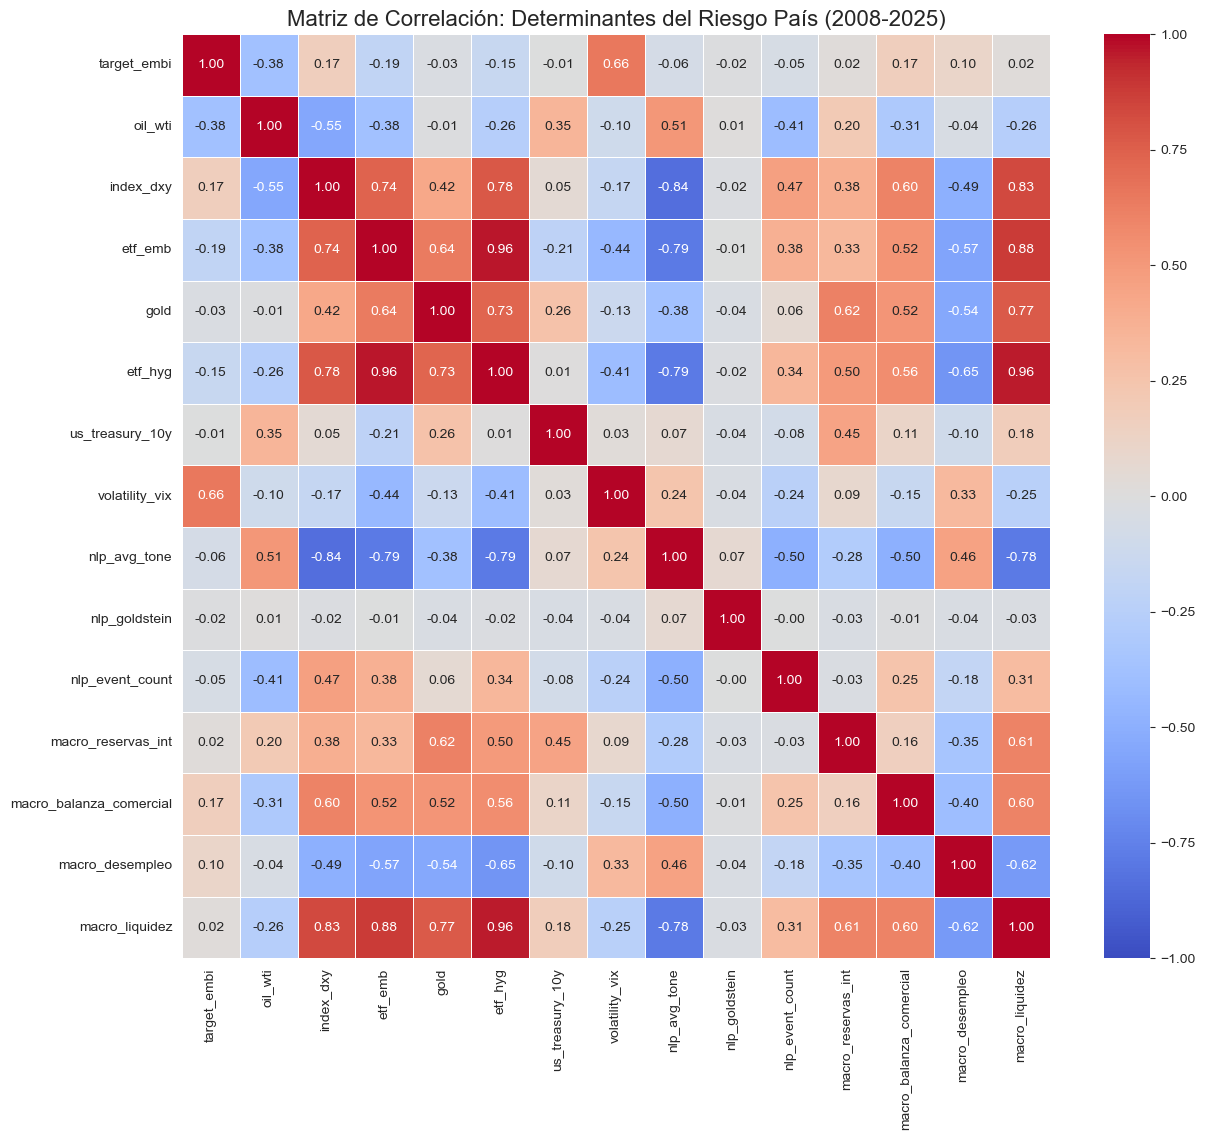

🔍 Ranking de correlación con el EMBI:
volatility_vix             0.656067
index_dxy                  0.166952
macro_balanza_comercial    0.165928
macro_desempleo            0.102810
macro_reservas_int         0.020506
macro_liquidez             0.016243
us_treasury_10y           -0.007516
nlp_goldstein             -0.015436
gold                      -0.028696
nlp_event_count           -0.048081
nlp_avg_tone              -0.064555
etf_hyg                   -0.153227
etf_emb                   -0.193174
oil_wti                   -0.381066
Name: target_embi, dtype: float64


In [14]:
# --- 6. ANÁLISIS DE CORRELACIÓN ---

# 1. Eliminar las variables que decidimos descartar
vars_to_drop = ['macro_remesas', 'macro_prod_petroleo']
df_final = df_master.drop(columns=vars_to_drop, errors='ignore')

print(f"Dimensiones finales del dataset: {df_final.shape}")

# 2. Calcular la Matriz de Correlación (Pearson)
corr_matrix = df_final.corr(method='pearson')

# 3. Visualización (Heatmap)
plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, 
            annot=True,        # Muestra los números
            fmt=".2f",         # 2 decimales
            cmap='coolwarm',   # Rojo (Positivo) - Azul (Negativo)
            linewidths=0.5,    # Líneas separadoras
            vmin=-1, vmax=1)   # Escala fija de -1 a 1

plt.title("Matriz de Correlación: Determinantes del Riesgo País (2008-2025)", fontsize=16)
plt.show()

# 4. Ranking de correlación con el Target (EMBI)
print("🔍 Ranking de correlación con el EMBI:")
print(corr_matrix['target_embi'].drop('target_embi').sort_values(ascending=False))

In [15]:
# 1. Descargamos SOLAMENTE el índice de fechas de un activo que cotiza igual que el EMBI
# Usamos el Tesoro a 10 años (^TNX) porque el EMBI es un spread sobre este bono.
# Si el Tesoro no opera, el EMBI tampoco.
print("⏳ Obteniendo calendario oficial de días de trading...")
calendario_trading = yf.download("^TNX", start='2008-01-01', end='2025-12-31', progress=False).index

# Asegurarnos de que el calendario no tenga zona horaria para evitar conflictos
calendario_trading = calendario_trading.tz_localize(None)

# 2. Filtramos tu dataset maestro
# Mantenemos SOLO las filas cuyo índice (fecha) exista en el calendario de trading real
# Esto elimina automáticamente: Sábados, Domingos y Festivos (4 de julio, Navidad, etc.)
df_clean_trading = df_master[df_master.index.isin(calendario_trading)].copy()

print(f"Filas antes de limpiar festivos/findes: {len(df_master)}")
print(f"Filas después (Días de Trading Reales): {len(df_clean_trading)}")

# Verificación visual
print("\nVerificando que no haya sábados (5) ni domingos (6) en el índice:")
print(df_clean_trading.index.dayofweek.value_counts().sort_index())

⏳ Obteniendo calendario oficial de días de trading...


C:\Users\danny\AppData\Local\Temp\ipykernel_2352\255631733.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  calendario_trading = yf.download("^TNX", start='2008-01-01', end='2025-12-31', progress=False).index


Filas antes de limpiar festivos/findes: 5878
Filas después (Días de Trading Reales): 4516

Verificando que no haya sábados (5) ni domingos (6) en el índice:
date
0    841
1    932
2    928
3    910
4    905
Name: count, dtype: int64


✅ Columnas de Lags creadas.
Dimensiones para correlación: (4486, 21)


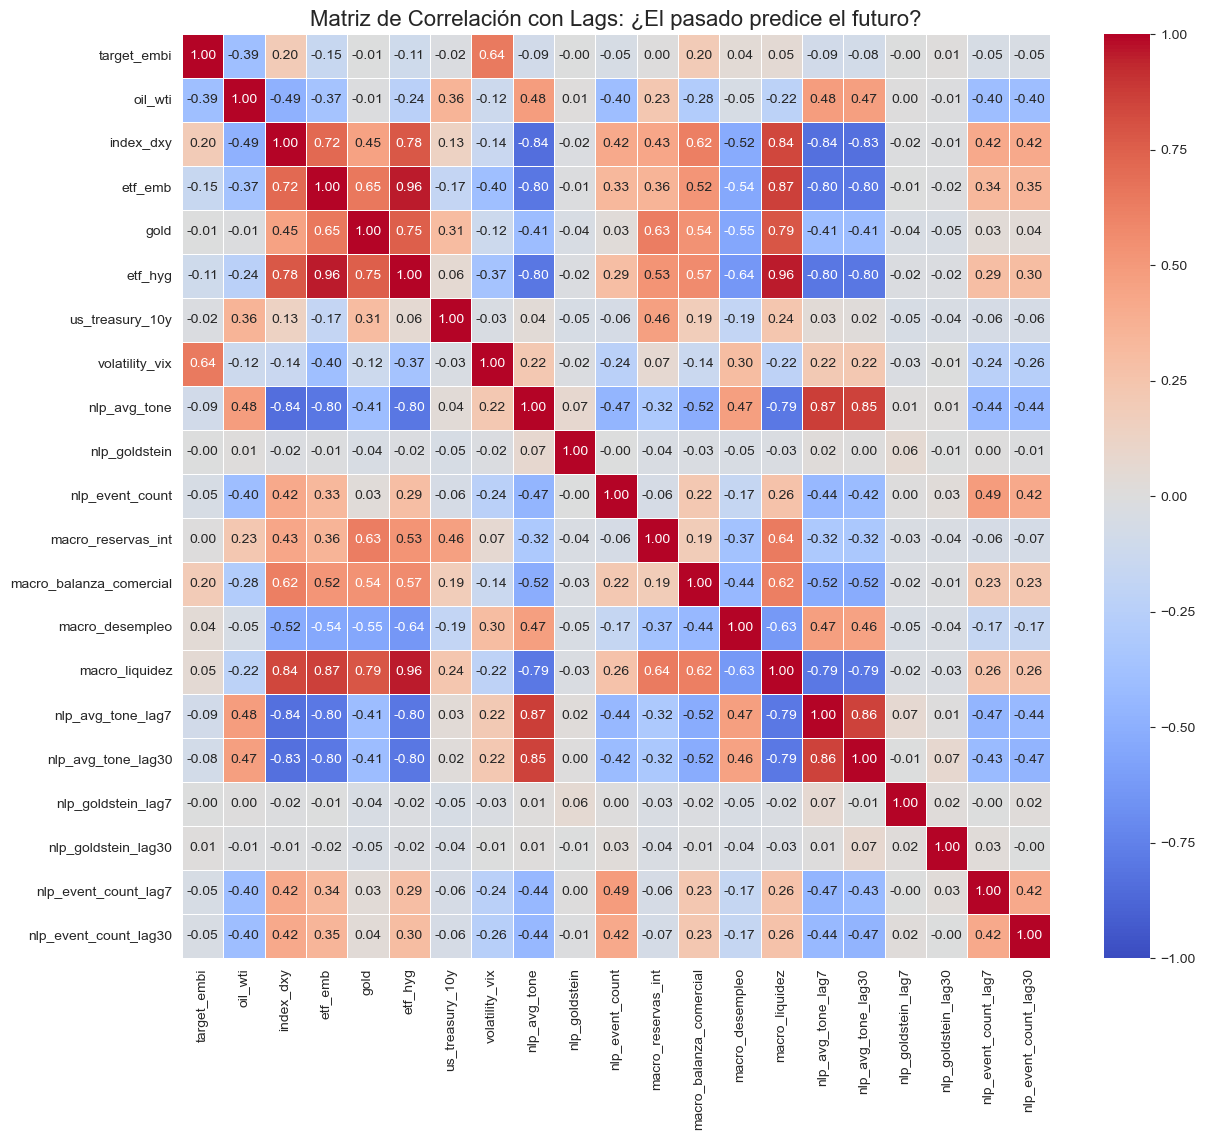

🔍 Ranking de correlación con el EMBI (Target):
volatility_vix             0.641906
macro_balanza_comercial    0.196945
index_dxy                  0.196398
macro_liquidez             0.052863
macro_desempleo            0.039204
nlp_goldstein_lag30        0.007860
macro_reservas_int         0.004748
nlp_goldstein_lag7        -0.002459
nlp_goldstein             -0.004044
gold                      -0.005071
us_treasury_10y           -0.023023
nlp_event_count_lag30     -0.046809
nlp_event_count_lag7      -0.052856
nlp_event_count           -0.053594
nlp_avg_tone_lag30        -0.080962
nlp_avg_tone              -0.092936
nlp_avg_tone_lag7         -0.093201
etf_hyg                   -0.107202
etf_emb                   -0.151299
oil_wti                   -0.391387
Name: target_embi, dtype: float64


In [16]:
# --- 6. ANÁLISIS DE LAGS Y CORRELACIÓN (Refactorizado) ---

# 1. Definimos las variables que queremos "rezagar" (NLP)
nlp_vars = ['nlp_avg_tone', 'nlp_goldstein', 'nlp_event_count']
lags = [7, 30]  # 7 días (semana) y 30 días (mes)

# 2. Creamos las columnas con Lags
# .shift(7) mueve los datos 7 días hacia abajo.
# Lo que pasó el día 1, ahora aparecerá alineado con el Riesgo País del día 8.
for var in nlp_vars:
    for lag in lags:
        nombre_col = f'{var}_lag{lag}'
        df_clean_trading[nombre_col] = df_clean_trading[var].shift(lag)

print("✅ Columnas de Lags creadas.")

# 3. Limpieza para la Matriz
# Eliminamos las variables que dijimos que no sirven (Remesas, Producción)
# Y eliminamos las filas iniciales que quedaron vacías (NaN) por culpa del shift de 30 días
vars_to_drop = ['macro_remesas', 'macro_prod_petroleo']
df_final = df_clean_trading.drop(columns=vars_to_drop, errors='ignore').dropna()

print(f"Dimensiones para correlación: {df_final.shape}")

# 4. Matriz de Correlación
plt.figure(figsize=(14, 12))
corr_matrix = df_final.corr(method='pearson')

# Filtramos para ver solo correlaciones con el TARGET (Opcional, pero ayuda a enfocar)
# O mostramos el mapa completo:
sns.heatmap(corr_matrix, 
            annot=True, 
            fmt=".2f", 
            cmap='coolwarm', 
            linewidths=0.5,
            vmin=-1, vmax=1)

plt.title("Matriz de Correlación con Lags: ¿El pasado predice el futuro?", fontsize=16)
plt.show()

# 5. El "Ranking" de la verdad
print("🔍 Ranking de correlación con el EMBI (Target):")
# Ordenamos de mayor a menor impacto (positivo o negativo)
print(corr_matrix['target_embi'].drop('target_embi').sort_values(ascending=False))


In [17]:
# Guardar el objeto exacto
df_final.to_pickle('dataset_tesis_final.pkl')
print("✅ Dataset guardado en Pickle (formato binario).")

✅ Dataset guardado en Pickle (formato binario).
